In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
#function to read ds while skipping starting lines
def load_citation_data(filepath):
    edges = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith("#"):
                continue
            src, dst = map(int, line.strip().split())
            edges.append((src, dst))
    return edges


In [4]:
#upload files
uploaded = files.upload()
#get filename in case it might differ (first key of dict)
filename = list(uploaded.keys())[0]

Saving citationds to citationds


In [5]:
# Build the graph
edges = load_citation_data(filename)
G = nx.DiGraph()
G.add_edges_from(edges)

print(f"Number of distinct papers in the dataset: {G.number_of_nodes()}")
print(f"Number of distinct citations in. the dataset: {G.number_of_edges()}")

Number of distinct papers in the dataset: 34546
Number of distinct citations in. the dataset: 421578


In [6]:
# dataframe with list of citation received and given by each paper
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

degree_df = pd.DataFrame({
    'in_degree': list(in_degrees.values()),
    'out_degree': list(out_degrees.values())
})

# summary
print(degree_df.describe()) #comment the summary, also in relation to paperrank

          in_degree    out_degree
count  34546.000000  34546.000000
mean      12.203381     12.203381
std       25.332252     15.224474
min        0.000000      0.000000
25%        1.000000      3.000000
50%        4.000000      8.000000
75%       13.000000     16.000000
max      846.000000    411.000000


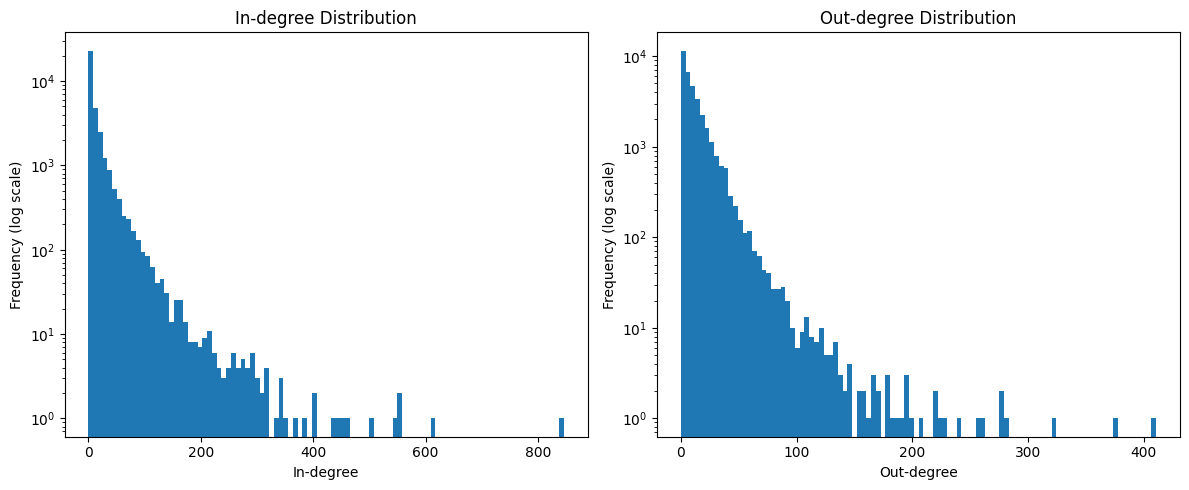

In [7]:
# Plot distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(degree_df['in_degree'], bins=100, log=True)
plt.title("In-degree Distribution")
plt.xlabel("In-degree")
plt.ylabel("Frequency (log scale)")

plt.subplot(1, 2, 2)
plt.hist(degree_df['out_degree'], bins=100, log=True)
plt.title("Out-degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()


In [8]:
#checking for isolated nodes
isolated_nodes = [node for node in G.nodes() if G.in_degree(node) == 0 and G.out_degree(node) == 0]
connected_nodes = [node for node in G.nodes() if node not in isolated_nodes]
print(f"Isolated papers: {len(isolated_nodes)}")
print(f"Connected papers: {len(connected_nodes)}")


Isolated papers: 0
Connected papers: 34546


Well, expected result

Research question is: will the top x papers change if accounting for the number of citations sent by sender, which is by using pagerank, vs simple In-Degree Centrality?

Why not trusted rank? Because papers get checked by external experts before being pubblished and in general are pubblished on trust-worthy media. Since trusted-rank comes with a few downsides, normal pr might be better.

As future work, given more data, like being able to cluster by topic, one could implement topic-specific pagerank, which could be interesting to compare.

In [9]:
#get top n summing citations(in-degree centrality)
def get_top_cited_papers(G, n=3):
    """
    Returns the top `n` most cited papers in the given graph based on incoming citations.
    in form of list of tuples (paper_id, citation_count), from most to least cited.
    """
    in_degrees = dict(G.in_degree())
    top_cited = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:n]
    return top_cited

#example to get top 10 citated papers id
top_cited_papers = get_top_cited_papers(G, n=10)

print("Top 10 papers by received citations:")
for paper_id, citation_count in top_cited_papers:
    print(f"Paper ID: {paper_id}, citations received: {citation_count:.6f}")

Top 10 papers by received citations:
Paper ID: 9803315, citations received: 846.000000
Paper ID: 9804398, citations received: 616.000000
Paper ID: 9407339, citations received: 557.000000
Paper ID: 9512380, citations received: 550.000000
Paper ID: 9606399, citations received: 542.000000
Paper ID: 9807344, citations received: 503.000000
Paper ID: 9306320, citations received: 464.000000
Paper ID: 9905221, citations received: 449.000000
Paper ID: 9408384, citations received: 444.000000
Paper ID: 9507378, citations received: 438.000000


In [10]:
#Using pagerank-like system to attribute a score to each node
def paperrank(G, alpha =0.85, max_iter =100, tolerance =1e-6):
    """
    Computes scores for all nodes in graph, use teleportation with probability alpha.
    max_iter and tolerance checks for convergence.
    tolerance is compared to how much the scores are changing from one iteration to the next (l1 norm)
    Returns dictionary with key node id and score.
    """
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    #score initialized
    pr = {node: 1 / N for node in nodes}

    for iteration in range(max_iter):
        new_pr = {}
        for node in nodes:
          #teleport part
            rank = (1 - alpha) / N

            # standard pr part
            for neighbor in G.predecessors(node):
                out_degree = G.out_degree(neighbor)
                if out_degree > 0:
                    rank += alpha * (pr[neighbor] / out_degree)

            new_pr[node] = rank

        # Check convergence using norm
        error = sum(abs(new_pr[node] - pr[node]) for node in nodes)
        pr = new_pr
        print(f"Iteration {iteration + 1}, error = {error:.2e}")
        if error < tolerance:
            break

    return pr

#application with default values
pr_scores = paperrank(G)

Iteration 1, error = 8.83e-01
Iteration 2, error = 3.46e-01
Iteration 3, error = 1.71e-01
Iteration 4, error = 1.07e-01
Iteration 5, error = 6.89e-02
Iteration 6, error = 3.92e-02
Iteration 7, error = 1.99e-02
Iteration 8, error = 9.24e-03
Iteration 9, error = 4.03e-03
Iteration 10, error = 1.68e-03
Iteration 11, error = 6.73e-04
Iteration 12, error = 2.65e-04
Iteration 13, error = 1.03e-04
Iteration 14, error = 4.06e-05
Iteration 15, error = 1.65e-05
Iteration 16, error = 7.04e-06
Iteration 17, error = 3.21e-06
Iteration 18, error = 1.58e-06
Iteration 19, error = 8.36e-07


In [11]:
#function to get the top n papers with new score
def get_top_paperrank_papers(pr_scores, n=3):
    """
    Returns the top n papers based on their Paperrank score (PageRank)
    require pr_scores (dict): A dictionary where keys are paper IDs and values are their Paperrank scores.
    gives a list of tuples: (paper_id, paperrank_score), sorted from most to least important.
    """
    # Sort by paperrank score (descending) and return the top n
    top_papers = sorted(pr_scores.items(), key=lambda x: x[1], reverse=True)[:n]

    return top_papers



In [12]:
#application for 10
top_papers = get_top_paperrank_papers(pr_scores, n=10)

print("Top 10 papers by Paperrank:")
for paper_id, score in top_papers:
    print(f"Paper ID: {paper_id}, Paperrank Score: {score:.6f}")

Top 10 papers by Paperrank:
Paper ID: 9303255, Paperrank Score: 0.001638
Paper ID: 9209205, Paperrank Score: 0.001265
Paper ID: 9310316, Paperrank Score: 0.001115
Paper ID: 9206203, Paperrank Score: 0.001035
Paper ID: 9208254, Paperrank Score: 0.000975
Paper ID: 9206242, Paperrank Score: 0.000854
Paper ID: 9803315, Paperrank Score: 0.000847
Paper ID: 9203203, Paperrank Score: 0.000835
Paper ID: 9303230, Paperrank Score: 0.000755
Paper ID: 9206236, Paperrank Score: 0.000726


In [13]:
#lets try another measure for centrality (betweenness)
#this would be even more interesting if we had topics cause it use
#shortest path between nodes  and it would reward "bridge" interdisciplinary topics
#takes too long to compute so i aproximate it by computing only over 500 nodes
#still takes 1 min to compute
bet_approx = nx.betweenness_centrality(G, k=500, seed=42)

In [29]:
#this function will come in handy later on
def get_top_betweenness_papers(betweenness_scores, n=10):
    sorted_nodes = sorted(betweenness_scores.items(), key=lambda x: x[1], reverse=True)
    top_nodes = sorted_nodes[:n]

    return top_nodes


top_bet = sorted(bet_approx.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 papers by betweenness centrality:")
for node, score in top_bet:
    print(f"Paper ID: {node}, Score: {score:.6f}")

Top 10 papers by betweenness centrality:
Paper ID: 206003, Score: 0.153924
Paper ID: 101224, Score: 0.108573
Paper ID: 9501384, Score: 0.078588
Paper ID: 9806301, Score: 0.077856
Paper ID: 9806471, Score: 0.062899
Paper ID: 103230, Score: 0.061366
Paper ID: 9809468, Score: 0.056143
Paper ID: 9901409, Score: 0.053087
Paper ID: 9904408, Score: 0.049275
Paper ID: 9910201, Score: 0.048697


In [54]:
def plot_top_paperrank_graph(G, paperrank_scores, top_n=100):
    # get top
    top_nodes_with_scores = get_top_paperrank_papers(paperrank_scores, top_n)
    # extract only id from tuples
    top_nodes = [node for node, _ in top_nodes_with_scores]

    subG = G.subgraph(top_nodes)
    pos = nx.kamada_kawai_layout(subG)
    sizes = [1000 * np.log10(paperrank_scores[node] + 1e-6) for node in subG.nodes()]

    # Debugging
    #print(f"Top nodes: {top_nodes[:5]}")
    #print(f"Number of nodes in subgraph: {subG.number_of_nodes()}")
    #print(f"Number of edges in subgraph: {subG.number_of_edges()}")
    #print(f"Node sizes (sample): {[paperrank_scores[node] for node in top_nodes[:5]]}")

    # Plot
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(subG, pos, node_size=sizes, alpha=0.8)
    nx.draw_networkx_edges(subG, pos, alpha=0.4)
    nx.draw_networkx_labels(subG, pos, font_size=8)
    plt.title(f"Top {top_n} Papers by PaperRank")
    plt.axis("off")
    plt.show()



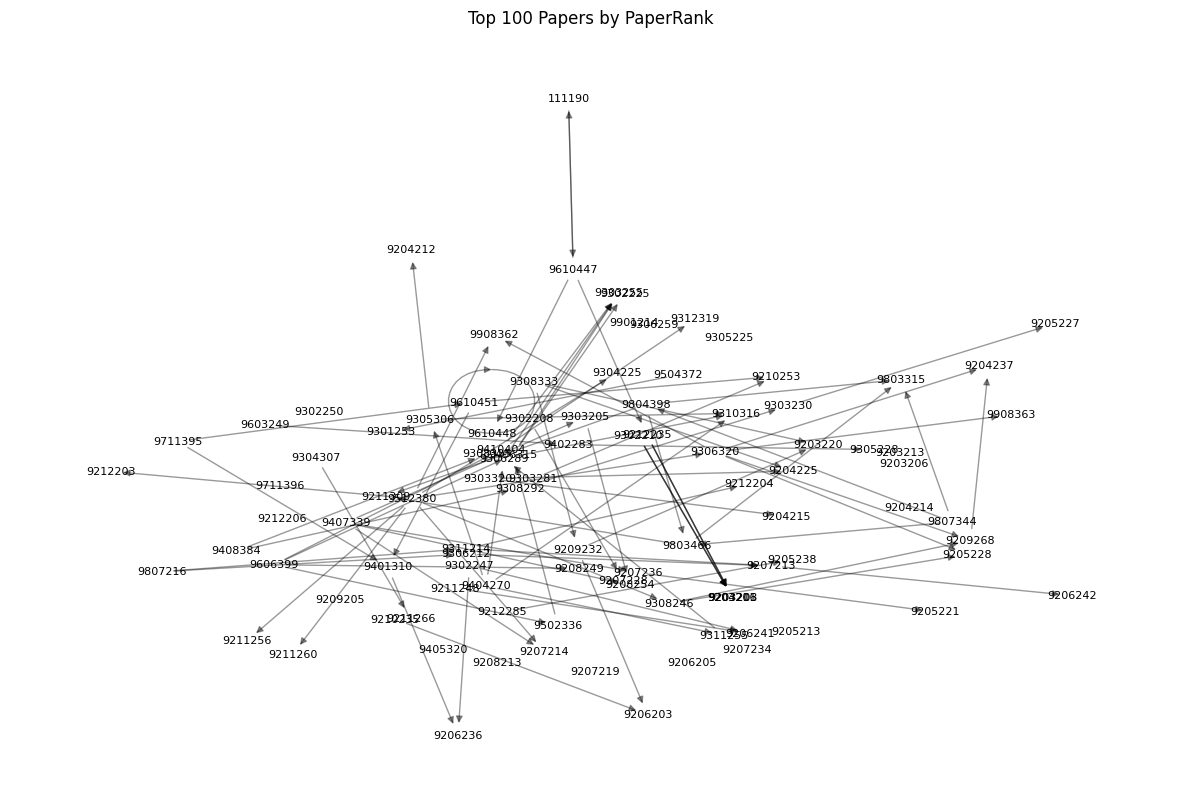

In [55]:
#application with default
plot_top_paperrank_graph(G, pr_scores)

In [52]:
def plot_top_betweenness_graph(G, betweenness_scores, top_n=100):
    # get top
    top_nodes_with_scores = get_top_betweenness_papers(betweenness_scores, top_n)
    # extract only id from tuples
    top_nodes = [node for node, _ in top_nodes_with_scores]

    subG = G.subgraph(top_nodes)
    pos = nx.kamada_kawai_layout(subG)
    sizes = [1000 * np.log10(betweenness_scores[node] + 1e-6) for node in subG.nodes()]


    # Plotting
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(subG, pos, node_size=sizes, alpha=0.8)
    nx.draw_networkx_edges(subG, pos, alpha=0.4)
    nx.draw_networkx_labels(subG, pos, font_size=8)
    plt.title(f"Top {top_n} Papers by Betweenness Centrality")
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


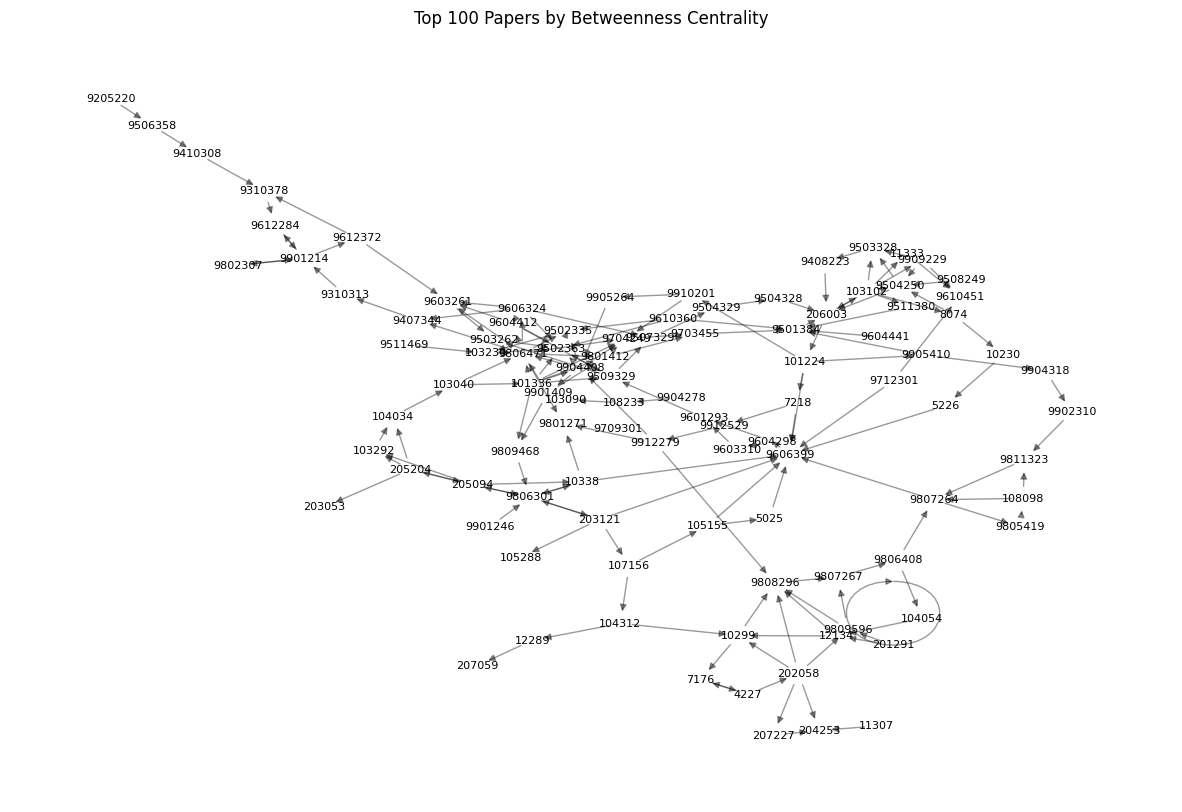

In [53]:
plot_top_betweenness_graph(G, bet_approx)

In [50]:
def plot_top_incoming_link_graph(G, top_n=100):
    # get top
    top_nodes_with_scores = get_top_cited_papers(G, top_n)
    # extract only id from tuples
    top_nodes = [node for node, _ in top_nodes_with_scores]

    subG = G.subgraph(top_nodes)
    pos = nx.kamada_kawai_layout(subG)
    sizes = [1000 * np.log10(G.in_degree[node] + 1e-6) for node in subG.nodes()]

    # Plot
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(subG, pos, node_size=sizes, alpha=0.8)
    nx.draw_networkx_edges(subG, pos, alpha=0.4)
    nx.draw_networkx_labels(subG, pos, font_size=8)
    plt.title(f"Top {top_n} Papers by Incoming Link Distance")
    plt.axis("off")
    plt.show()



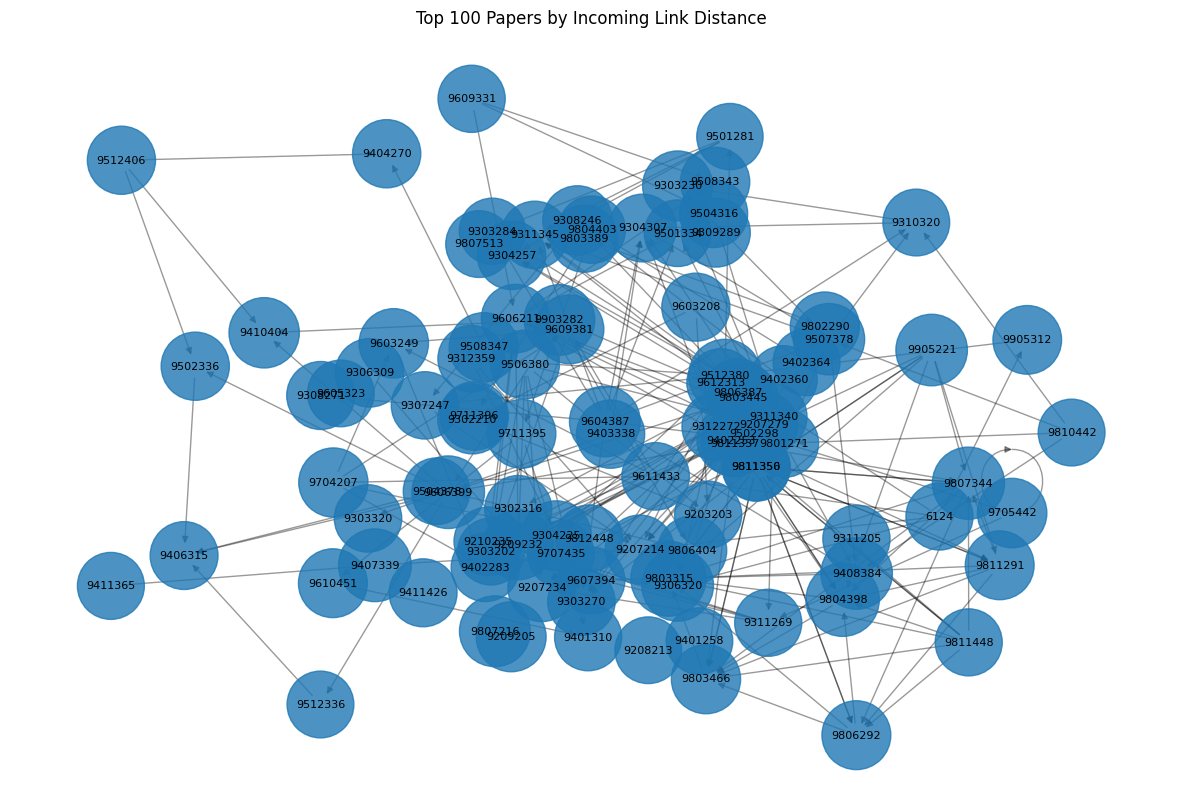

In [51]:
#application
plot_top_incoming_link_graph(G)